In [13]:
import math
import numpy as np
import itertools

class CarStates:
  empty=0
  with_passanger=1
  total=2

class TaxiMDP:
    def __init__(
        self,
        square_size=5,
        passegner=(0, 0),
        car=(4, 1),
        target=(3,4)
    ):
        self.square_size = square_size
        self.passenger_start_position = passegner
        self.car_start_position = car
        self.target = target
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        self.car_state = CarStates.empty
        self.reset()


    def reset(self):
        self.car = self.car_start_position
        self.passenger = self.passenger_start_position
        self.car_state = CarStates.empty

    def _is_out_of_field(self, row, col):
        if row < 0 or row > self.square_size - 1:
            return True
        if col < 0 or col > self.square_size - 1:
            return True
        return False

    def get_action_mask(self, state):
        mask = np.ones((len(self.actions)), dtype = int)
        for i, a in enumerate(self.actions):
            if self._is_out_of_field(state[0] + a[0], state[1] + a[1]):
                mask[i] = 0
        return mask
    
    def reward(self, state):
        reward = -1
        row, col, car_state = state
        if (
            car_state == CarStates.empty
            and (row, col) == tuple(self.passenger)
        ):
            reward = 10
        elif (
            car_state == CarStates.with_passanger
            and (row, col) == tuple(self.target)
        ):
            reward = 10
        return reward


    def next_state(self, state , a:int):
        a_dir = self.actions[a]
        row, col, car_state = state
        if (
            car_state == CarStates.empty
            and row == self.passenger[0] 
            and col == self.passenger[1]
        ):
            self.car_state = CarStates.with_passanger
            return self.get_state()

        mask = self.get_action_mask(state)
        if mask[a] > 0:
            return (row + a_dir[0], col + a_dir[1], car_state)
        else:
            return state

    def get_state(self):
        return self.car[0], self.car[1], self.car_state

    def step(self, a:int):
        new_sate = self.next_state(self.get_state(), a)
        r = self.reward(new_sate)
        row, col, _ = new_sate
        self.car = np.array([row, col])
        if self.car_state == CarStates.with_passanger:
            self.passenger = np.array([row, col])
        terminated = False
        if tuple(self.passenger) == tuple(self.target):
            terminated = True;
        return new_sate, r, terminated

    def get_default_policy(self):
        policy = np.zeros((self.square_size, self.square_size, CarStates.total, len(self.actions)), dtype=float)
        for row, col, car_state in itertools.product(range(self.square_size), range(self.square_size), range(CarStates.total)):
            a_mask = self.get_action_mask((row, col, car_state))
            policy[row, col, car_state] = a_mask/a_mask.sum()
        return policy

    def sample_with_policy(self, policy, random_action = False):
        prob = policy[self.car[0], self.car[1], self.car_state]
        if random_action:
            a = np.random.default_rng().choice(len(self.actions), p=prob)
        else:
            a = np.argmax(prob)
        return self.step(a)

    def get_total_states(self):
        return self.square_size**2 * CarStates.total

    def decode_state_from_index(self, index:int):
        car_state = CarStates.empty
        if index >= self.square_size**2:
            car_state = CarStates.with_passanger
            index -= self.square_size**2

        row = index // self.square_size
        col = index % self.square_size
        return (row, col, car_state)

    def encode_state_to_index(self, state):
        index = 0
        index += state[0] * self.square_size
        index += state[1]
        index += self.square_size**2 * state[2]
        return index


In [14]:
import random
square_size = 5

positions = [(x, y) for x, y in itertools.product(range(square_size), range(square_size))]

random_positions = random.sample(positions, 3) # сэмплируем координаты

env = TaxiMDP(
    square_size=square_size,
    passegner=random_positions[0],
    car=random_positions[1],
    target=random_positions[2]
)
random_positions #  пасажир машина и точка назначения

[(2, 2), (0, 0), (4, 0)]

In [15]:
def calc_V(env, policy):

  n_states = env.get_total_states()
  V = np.zeros((n_states))
  threshold = 0.01
  gamma = 0.99
  steps = 0
  while True:
    delta = 0
    for state_index in range(n_states):
          state = env.decode_state_from_index(state_index)
          action_probs = policy[state]
          v = V[state_index]
          r = env.reward(state)
          s_n = []
          for a, prob in enumerate(action_probs):
            v_index = env.encode_state_to_index(env.next_state(state, a))
            s_n.append(prob * V[v_index])
          V[state_index] = r + gamma * sum(s_n)
          delta = max(delta, abs(v - V[state_index]))
    if delta < threshold:
          break
    steps+=1
  return V, steps

def softmax(x):
    """Вычисление softmax для списка значений."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def stochastic_policy_improvement(V, env, gamma = 0.9):
    policy = env.get_default_policy()  # Используем dtype=object для хранения массивов вероятностей
    for index, v_val in enumerate(V):
      state = env.decode_state_from_index(index)
      action_values = np.array([v_val + gamma * V[env.encode_state_to_index(env.next_state(state, a))] for a in range(len(env.actions))])
      policy[state] = softmax(action_values)

    return policy

total steps: 253
Passanger coords: (2, 2)


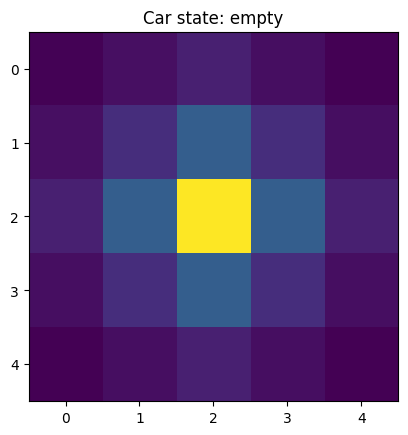

Target coords: (4, 0)


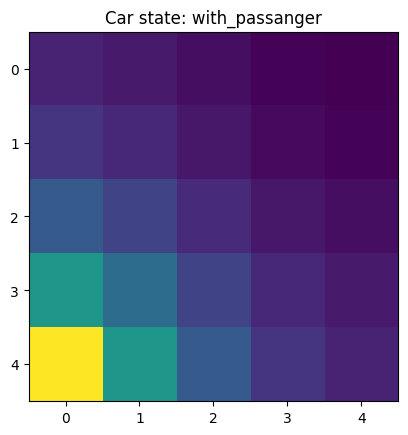

In [16]:
import matplotlib.pyplot as plt
env.reset()
policy = env.get_default_policy()
v, steps = calc_V(env, policy)
print(f'total steps: {steps}')
print(f'Passanger coords: {random_positions[0]}')
plt.title('Car state: empty')
plt.imshow(v.reshape((-1, env.square_size))[:5]);
plt.show();

plt.title('Car state: with_passanger')
print(f'Target coords: {random_positions[2]}')
plt.imshow(v.reshape((-1, env.square_size))[5:]);
plt.show(); # тут показано что для каждого из двух состояний машины V максимален в точке взятия или доставки пассажира 

total steps: 688
Passanger coords: (2, 2)


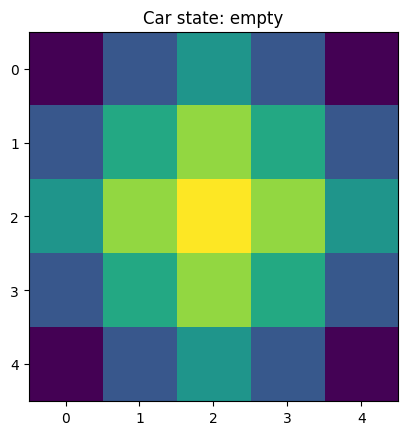

Target coords: (4, 0)


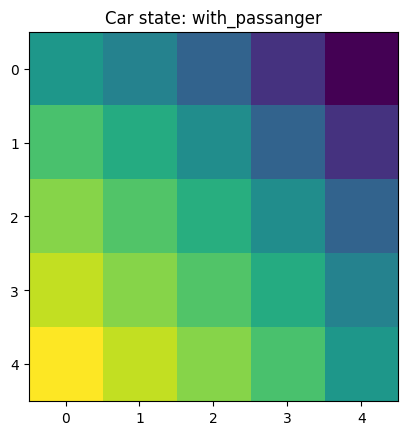

In [17]:
stoh_policy = stochastic_policy_improvement(v, env)

env.reset()
v_stoh, steps = calc_V(env, stoh_policy)
print(f'total steps: {steps}')
print(f'Passanger coords: {random_positions[0]}')
plt.title('Car state: empty')
plt.imshow(v_stoh.reshape((-1, env.square_size))[:5]);
plt.show();

plt.title('Car state: with_passanger')
print(f'Target coords: {random_positions[2]}')
plt.imshow(v_stoh.reshape((-1, env.square_size))[5:]);
plt.show();

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import time

def draw_env(env, i):
    field = np.zeros((env.square_size, env.square_size));

    plt.figure();
    plt.imshow(field, cmap='Greys', interpolation='nearest');

    plt.scatter(env.passenger[0], env.passenger[1], color='blue', marker='o', s=200);
    plt.scatter(env.car[0], env.car[1], color='red', marker='o', s=200);
    plt.scatter(env.target[0], env.target[1], color='black', marker='o', s=200);

    plt.grid(True);

    plt.xticks(range(env.square_size), range(env.square_size));
    plt.yticks(range(env.square_size), range(env.square_size));

    plt.savefig(f"./images/plot_{i}.png")
    return f"./images/plot_{i}.png"

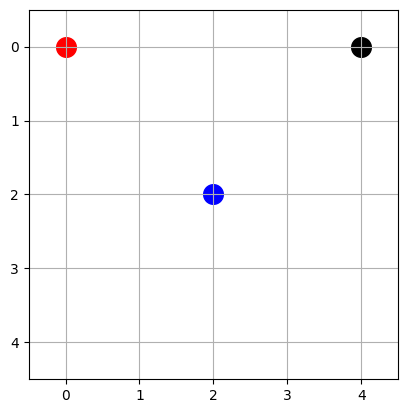

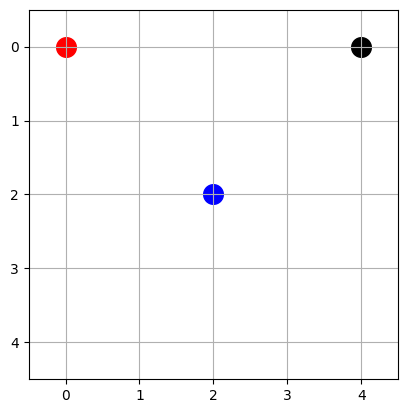

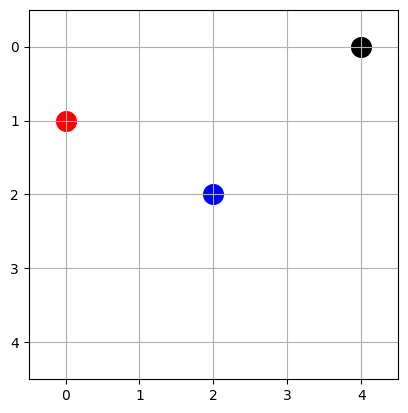

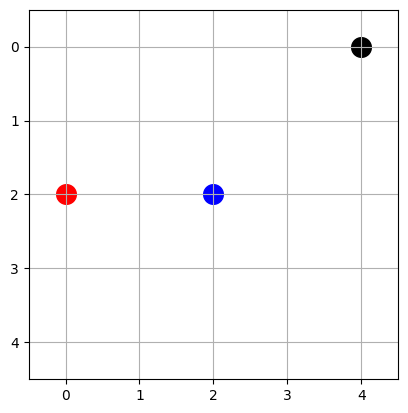

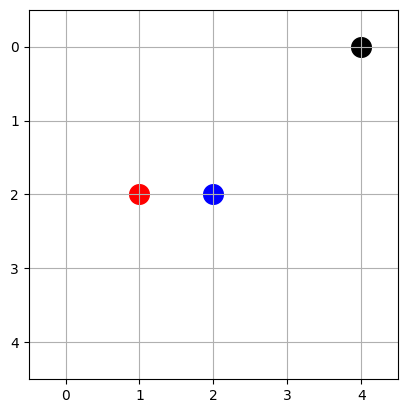

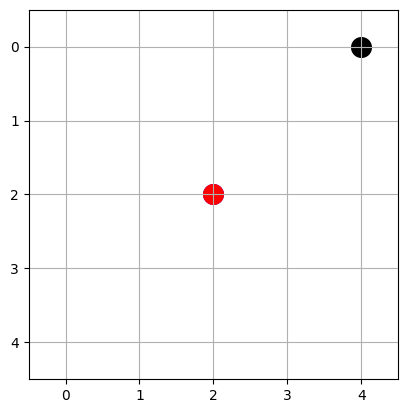

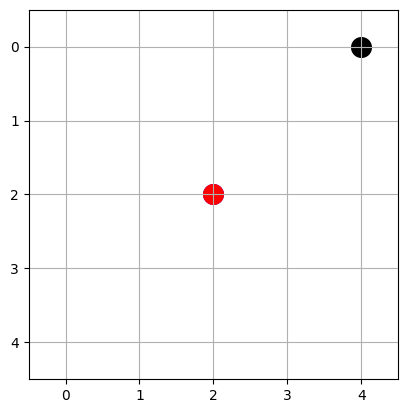

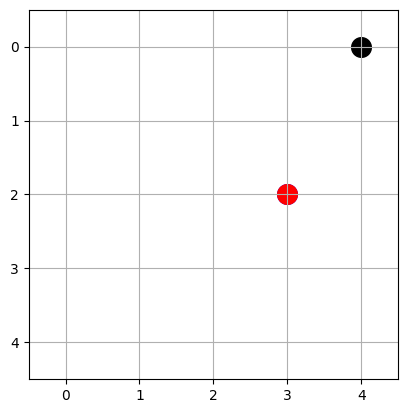

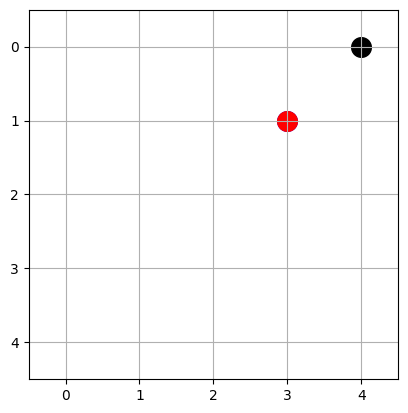

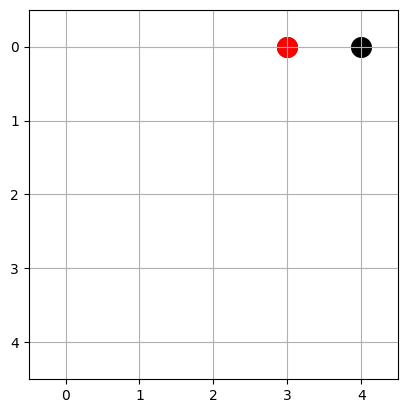

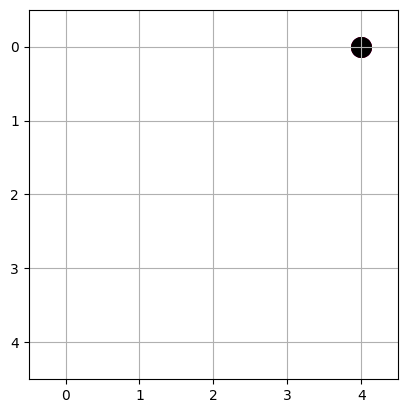

In [19]:
image_path = []
env.reset()
state = env.get_state()
total_reward = 0 
done = False
i = 0
image_path.append(draw_env(env, i))
while not done:
    i += 1
    a = np.random.choice(a=list(range(4)), p=stoh_policy[state])
    state, reward, done = env.step(a) 
    total_reward += reward
    image_path.append(draw_env(env, i))

In [20]:
total_reward

12

In [21]:
from IPython.display import display, HTML
import imageio
import os

images = []
for img in image_path:
    images.append(imageio.imread(img))

# Сохраняем гифку
imageio.mimsave('stoh_policy.gif', images)

# Удаляем временные файлы
for img in image_path:
    os.remove(img)

/tmp/ipykernel_420564/3860912362.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img))


/tmp/ipykernel_420564/3621501604.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure();


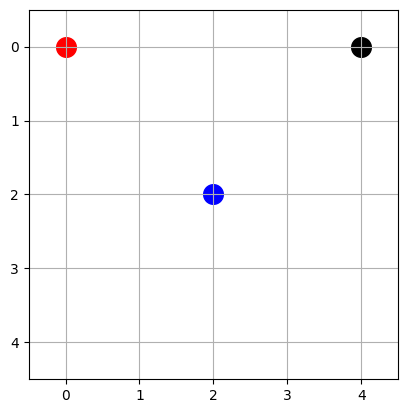

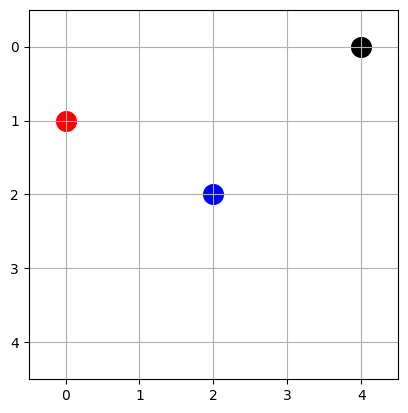

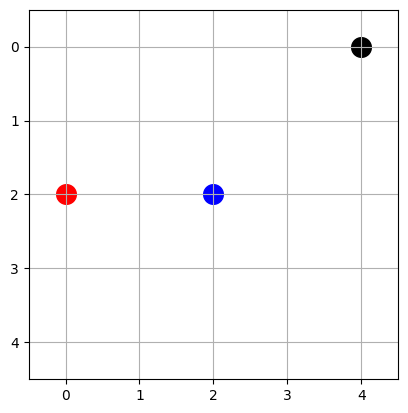

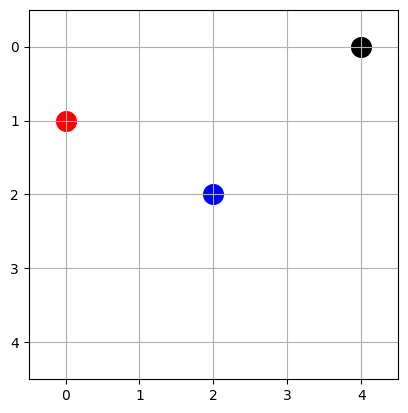

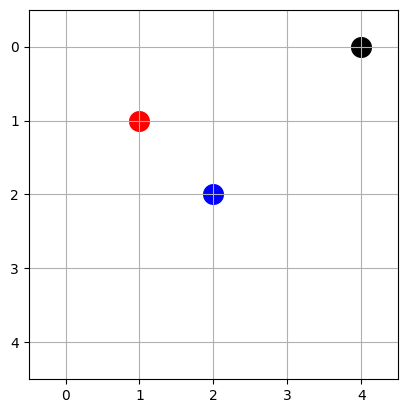

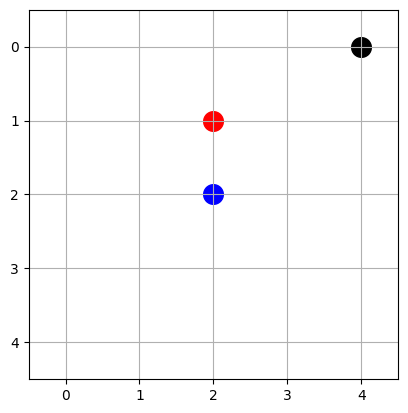

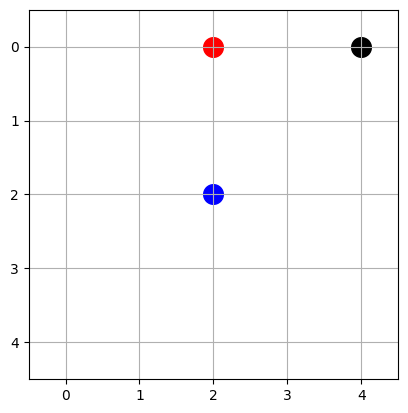

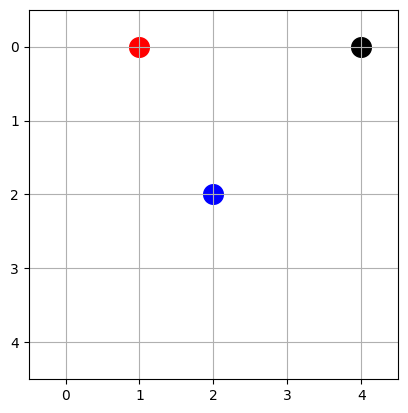

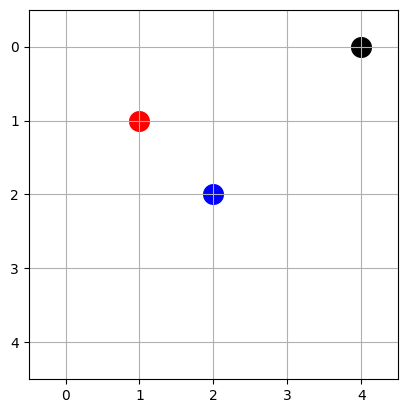

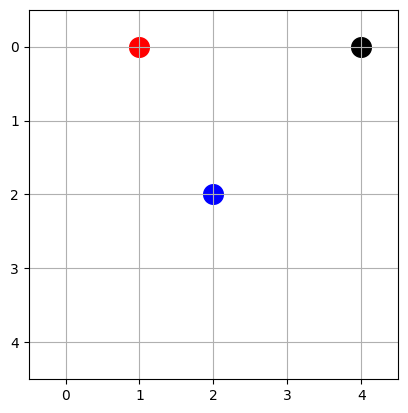

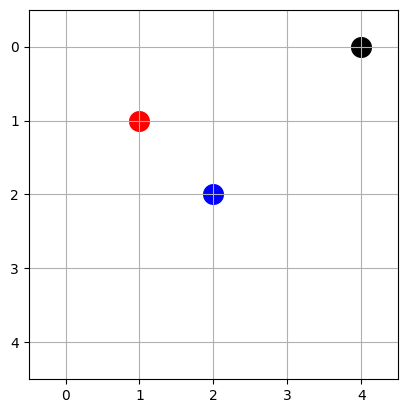

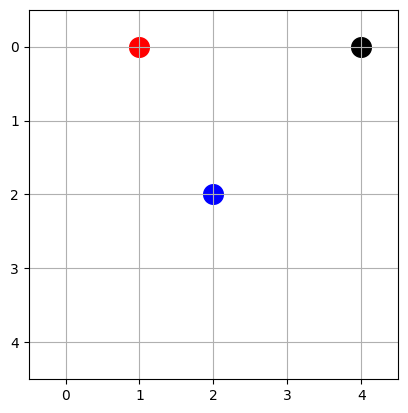

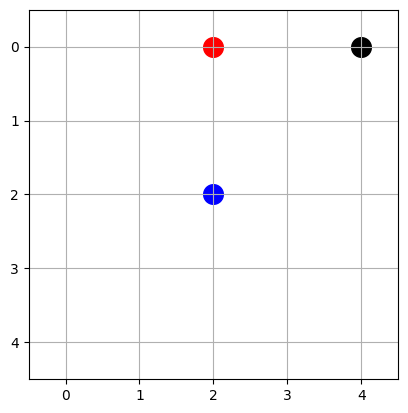

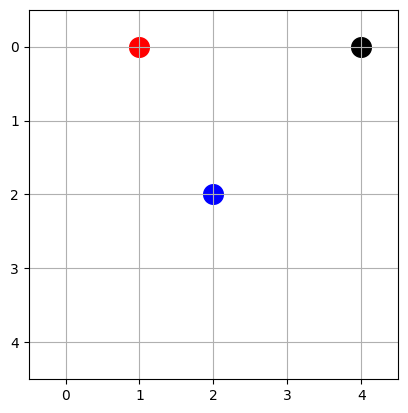

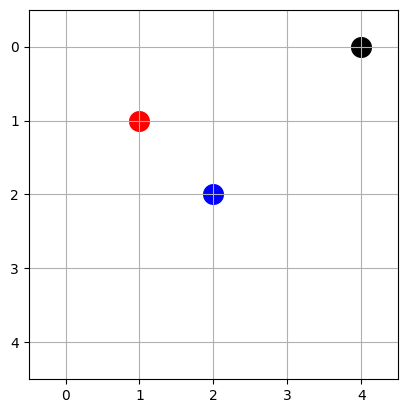

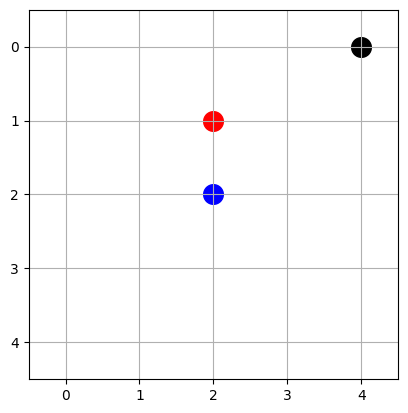

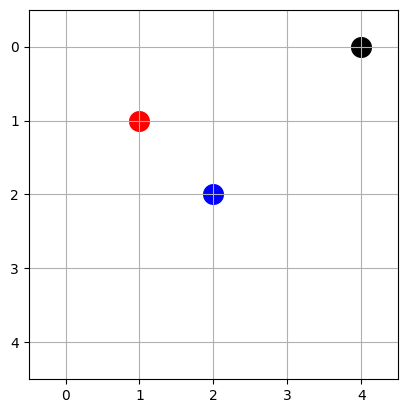

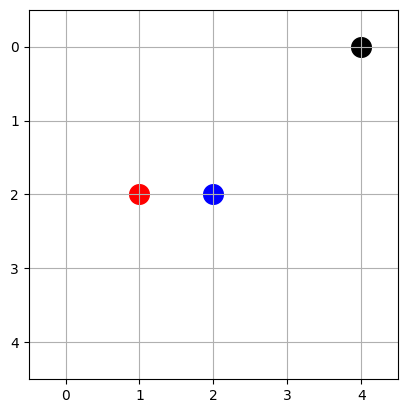

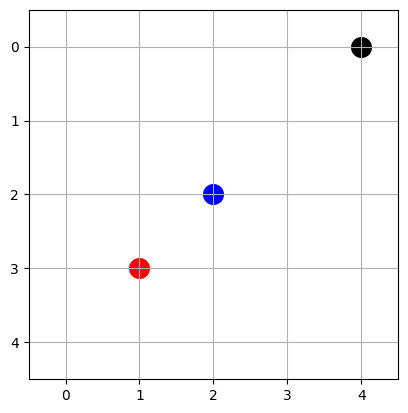

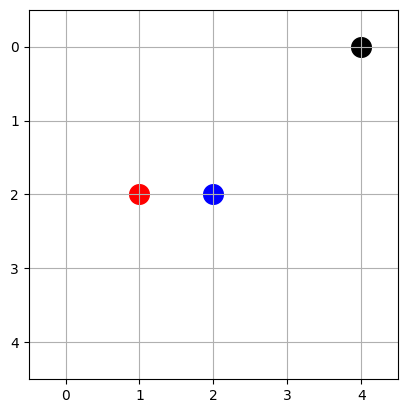

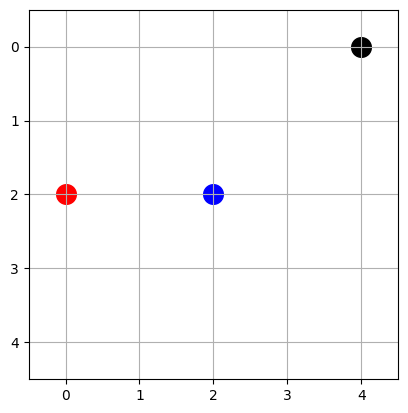

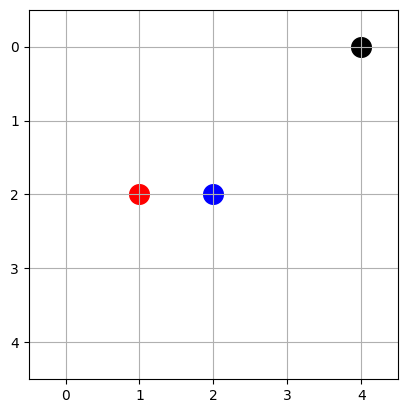

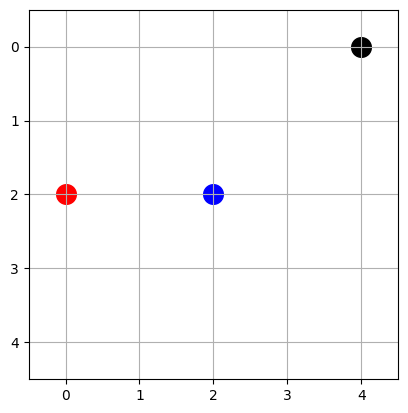

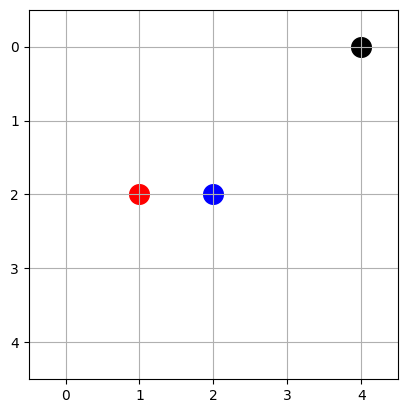

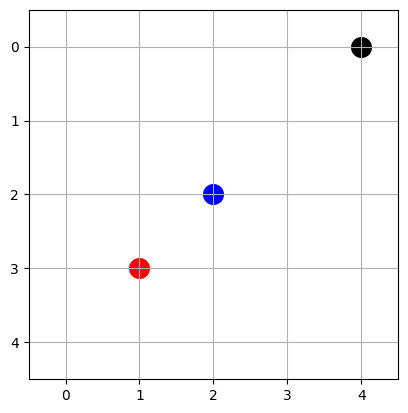

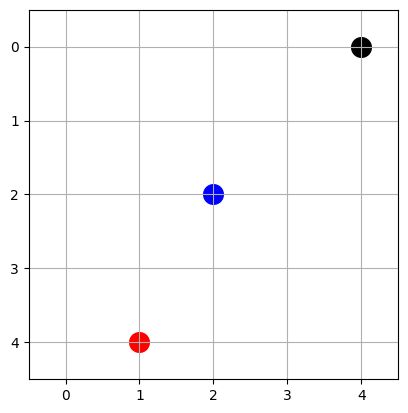

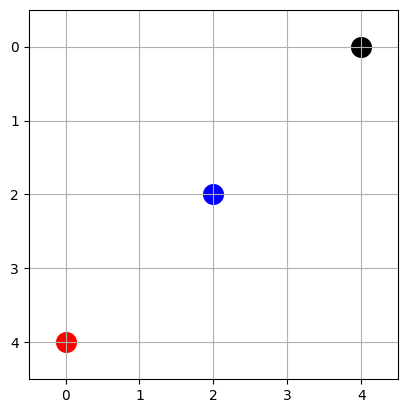

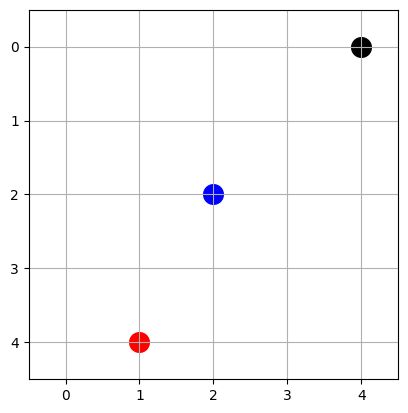

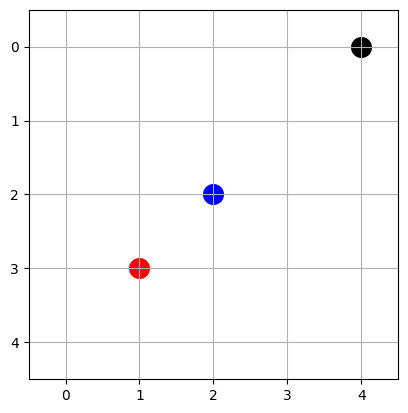

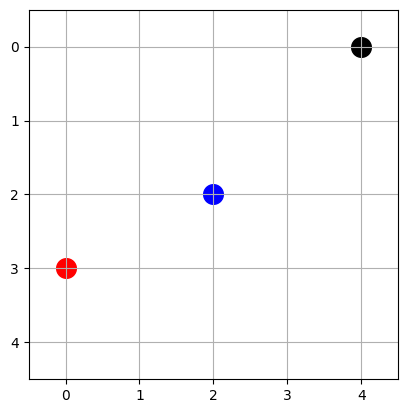

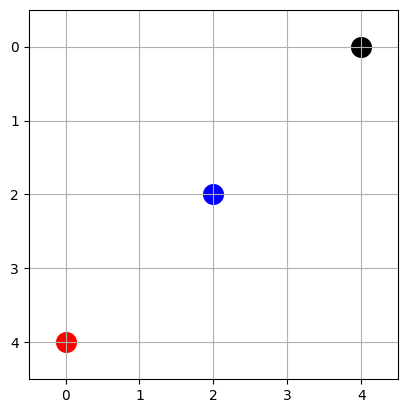

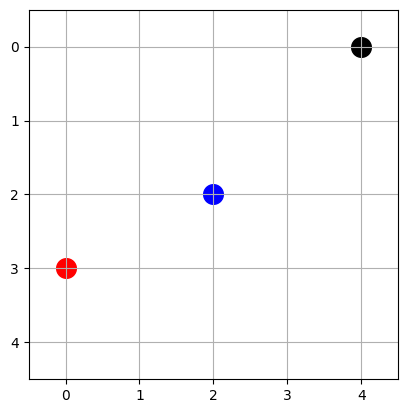

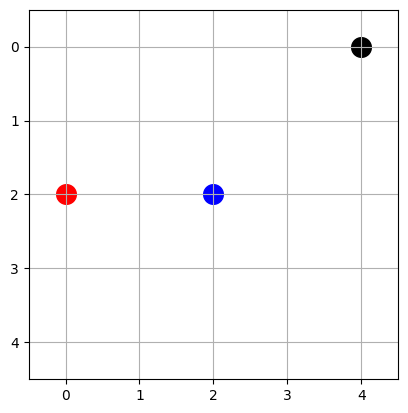

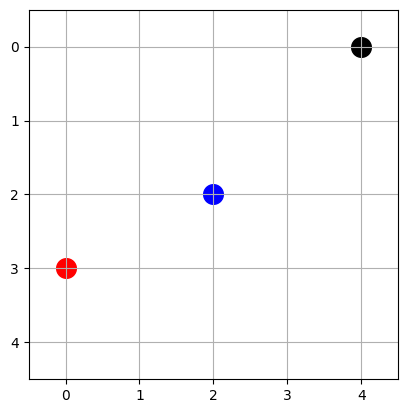

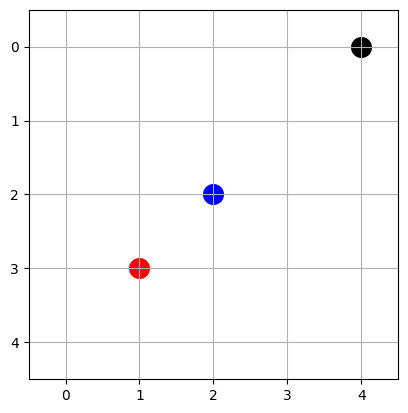

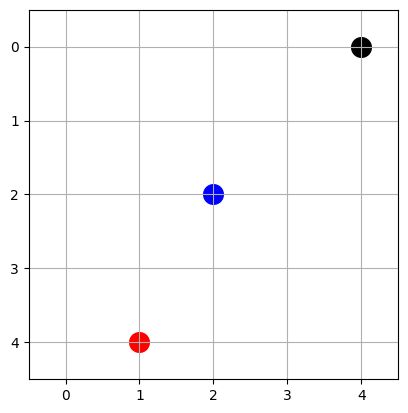

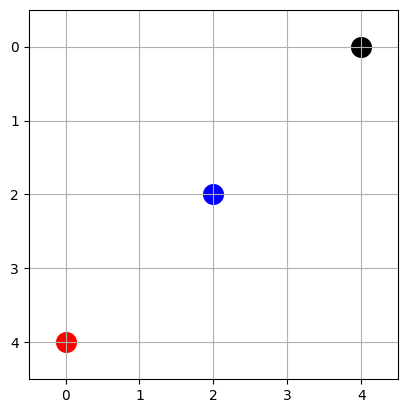

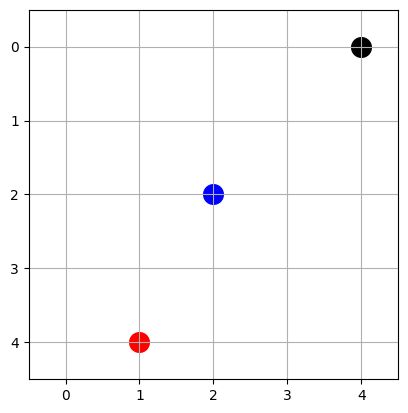

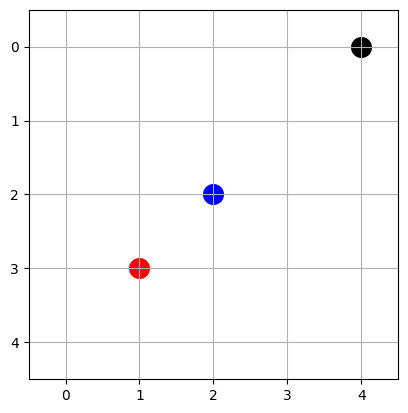

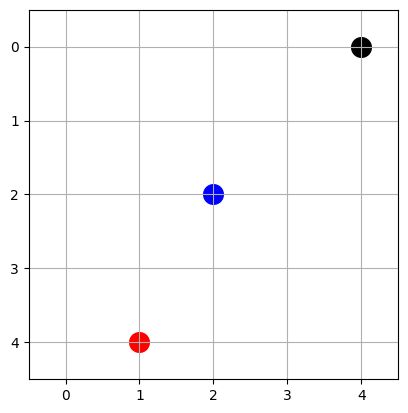

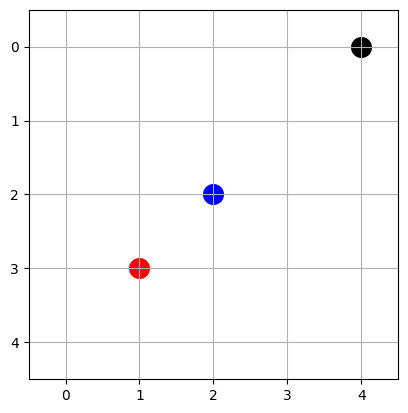

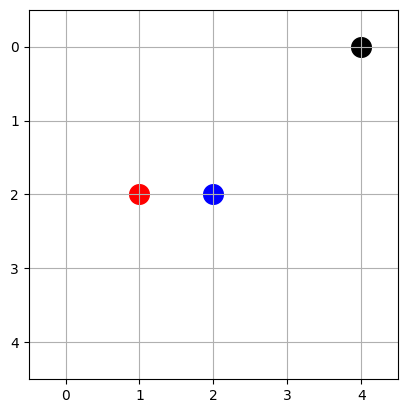

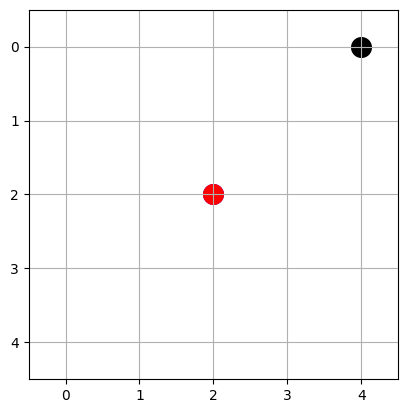

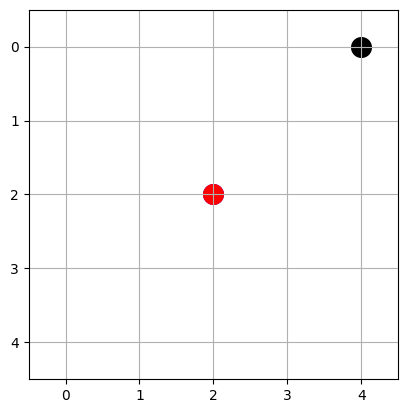

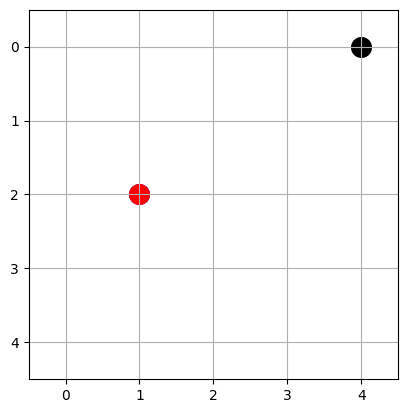

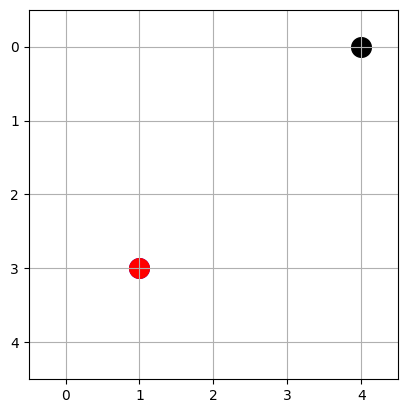

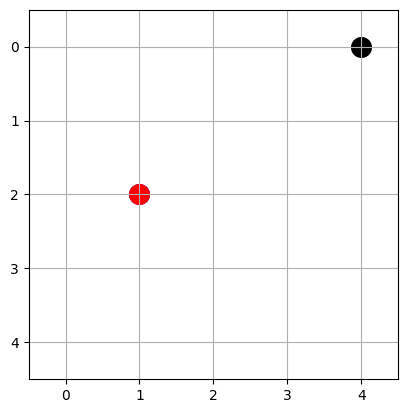

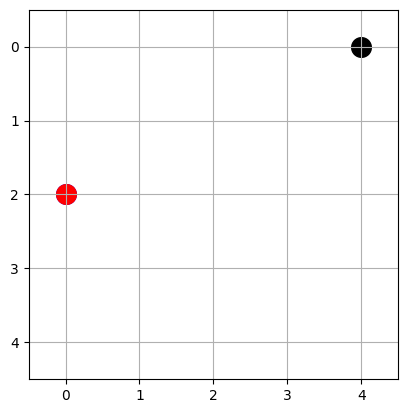

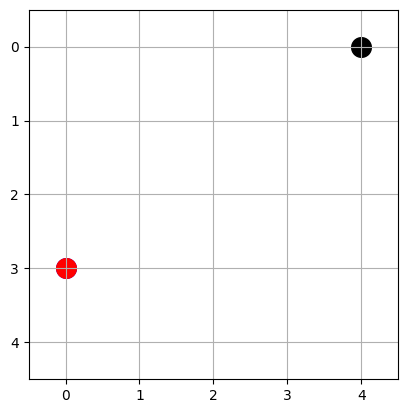

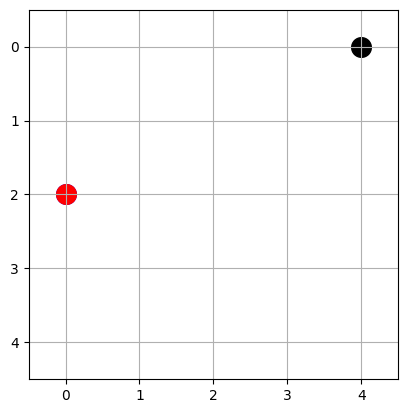

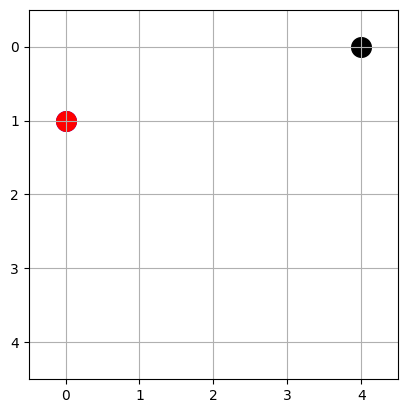

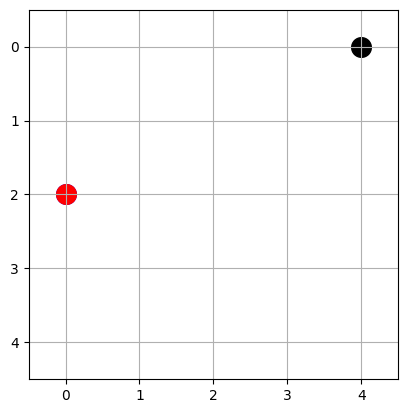

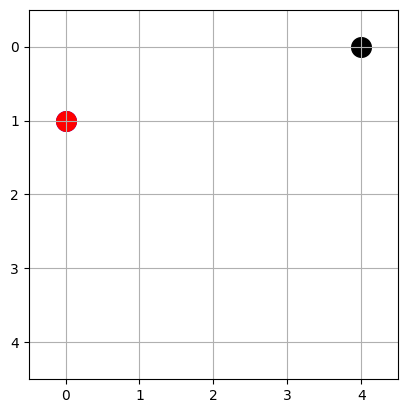

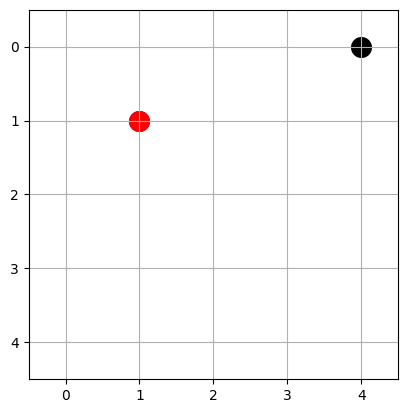

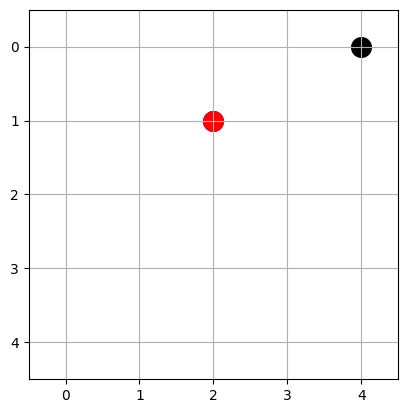

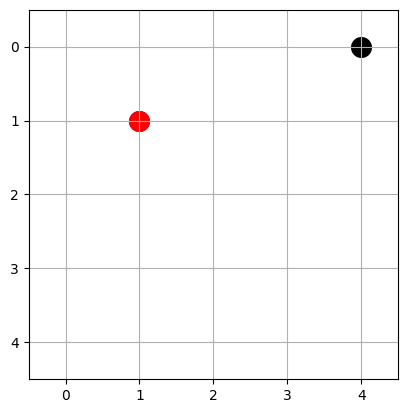

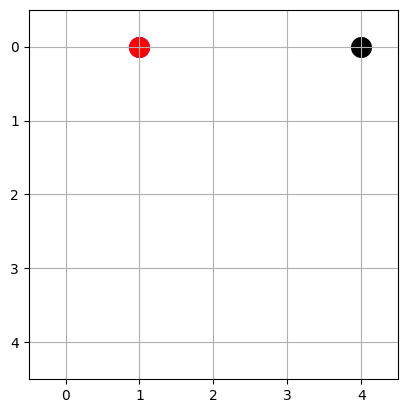

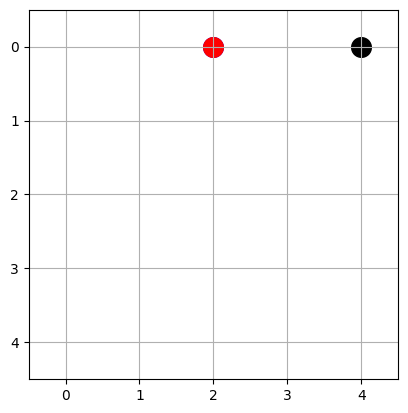

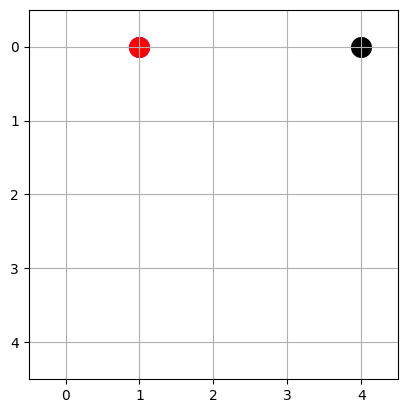

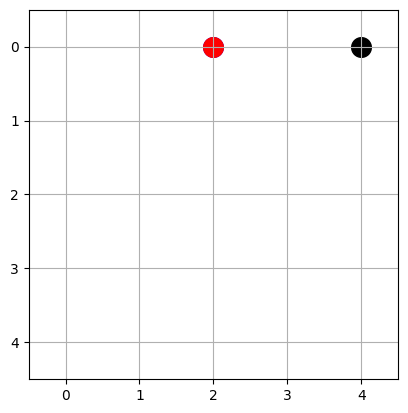

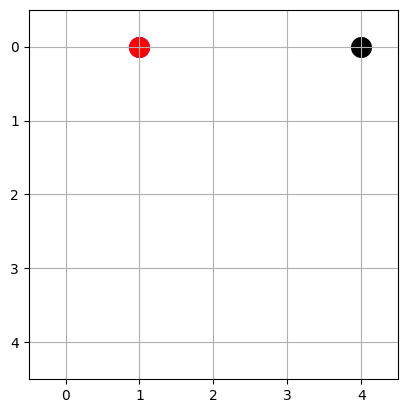

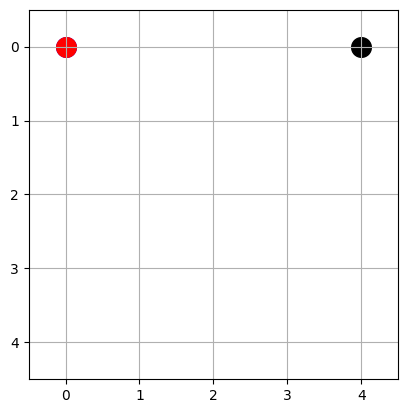

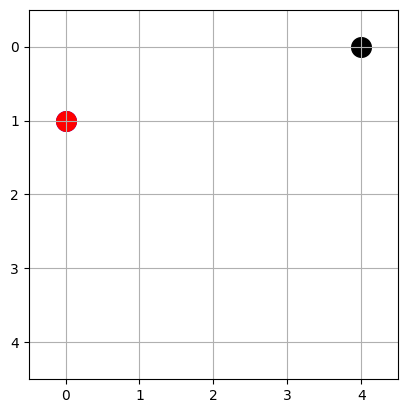

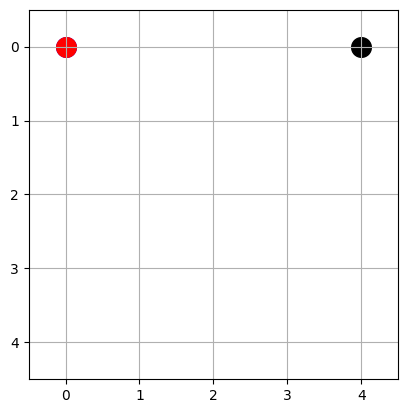

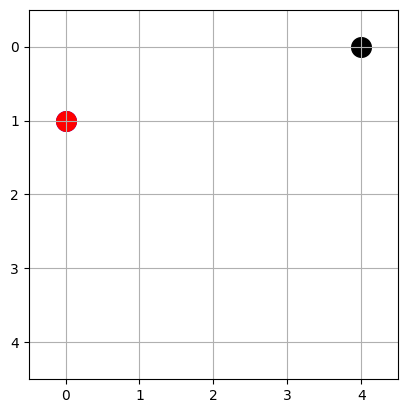

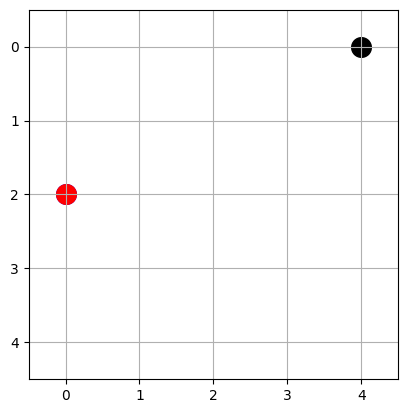

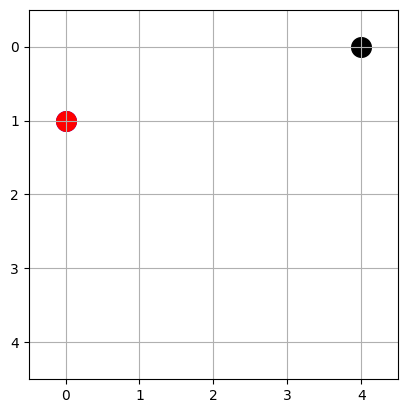

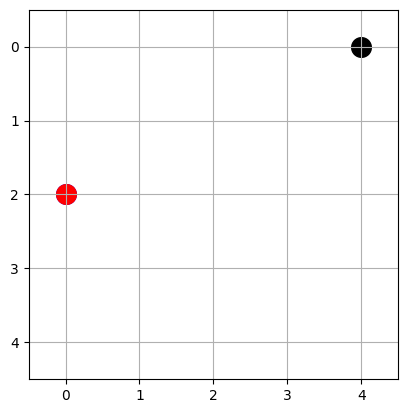

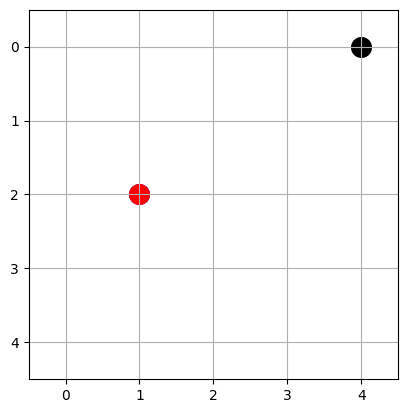

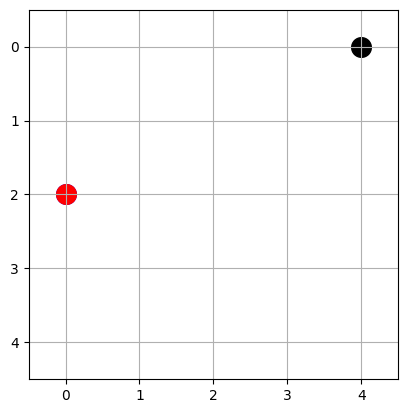

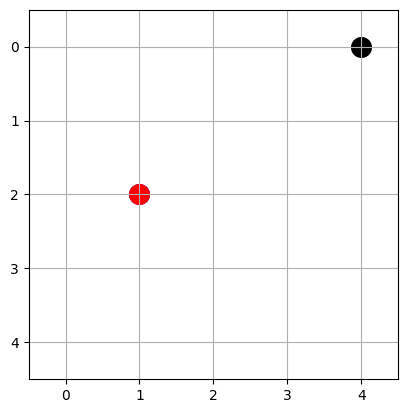

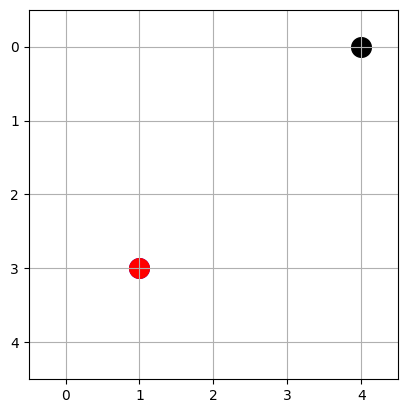

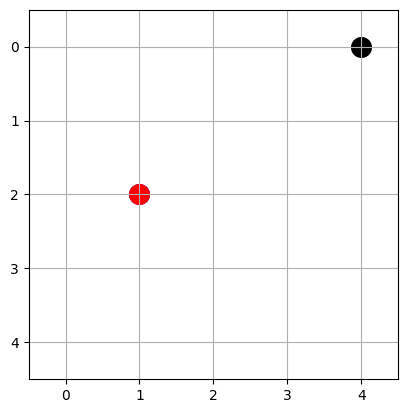

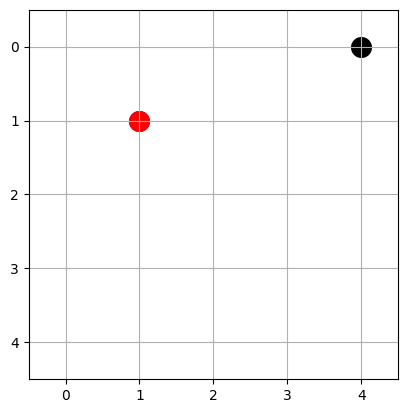

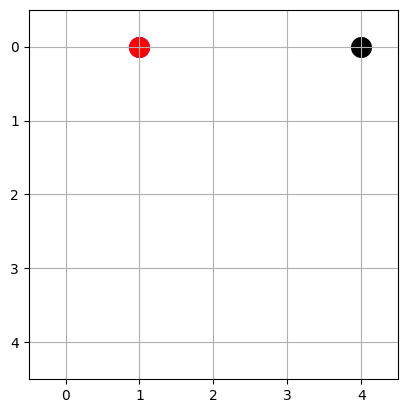

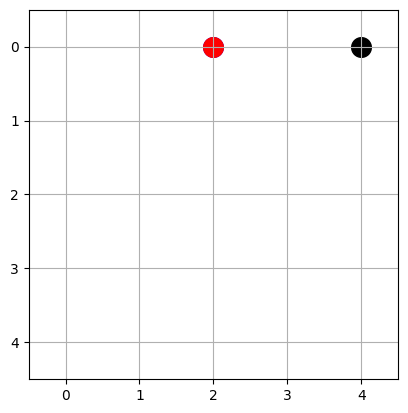

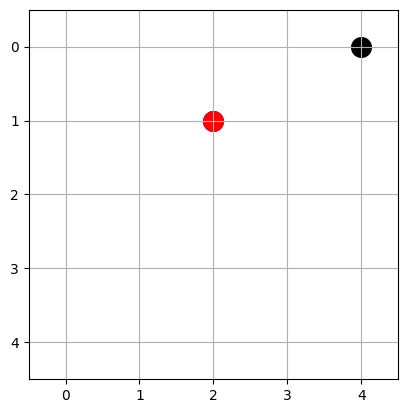

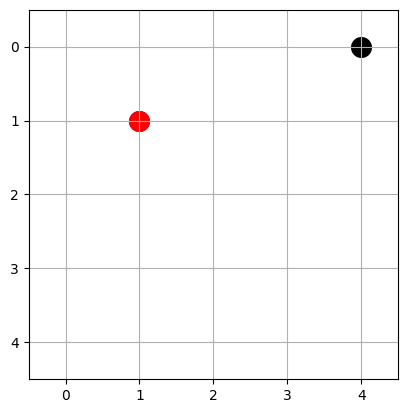

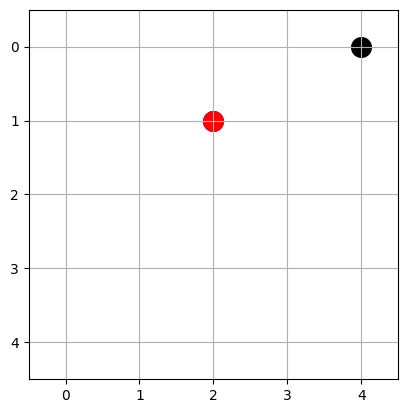

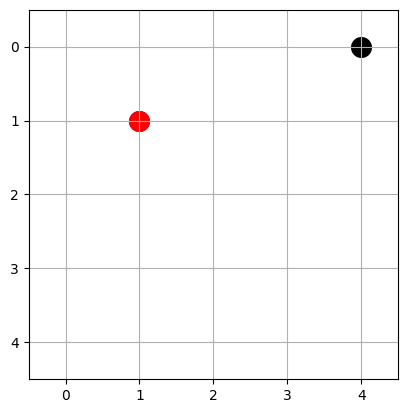

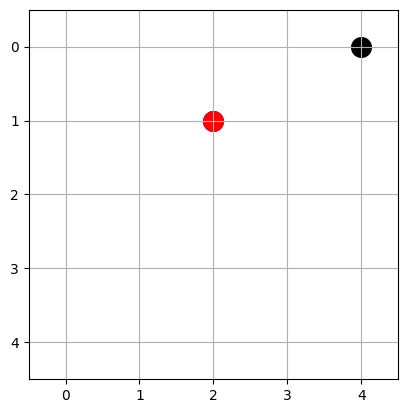

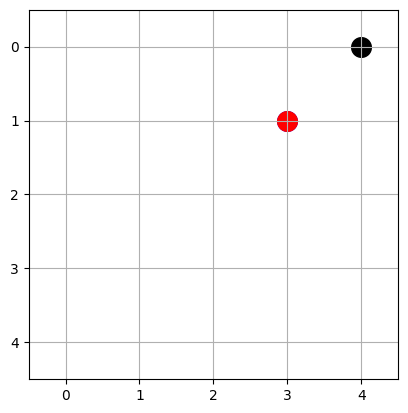

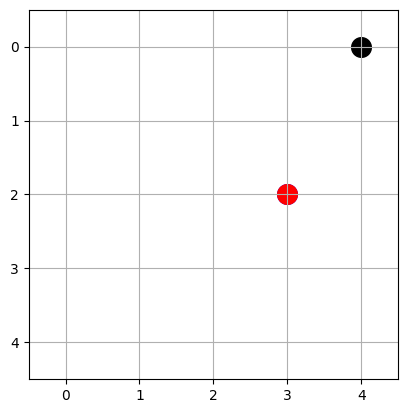

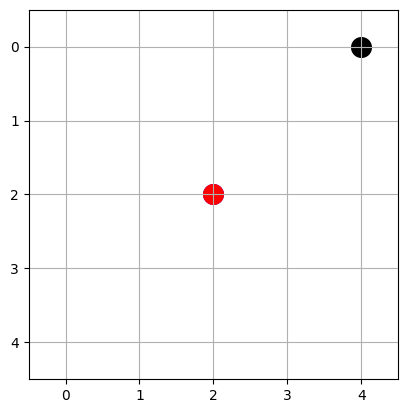

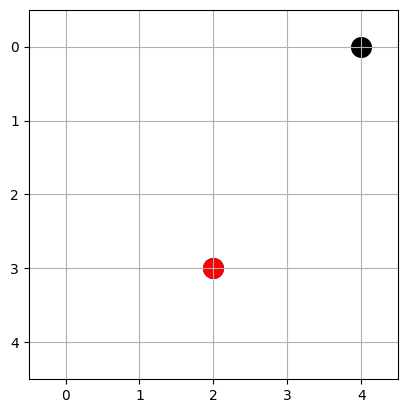

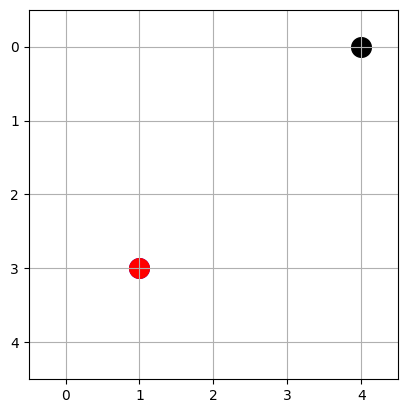

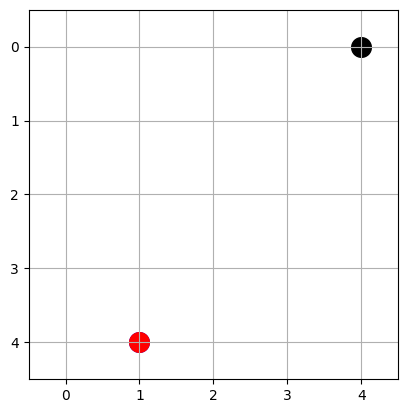

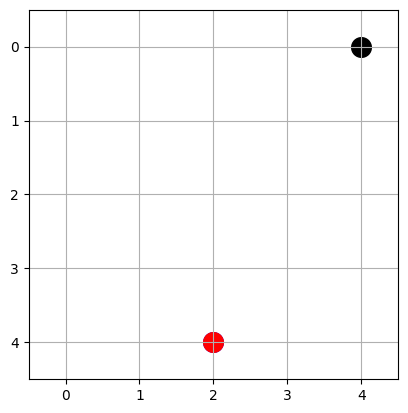

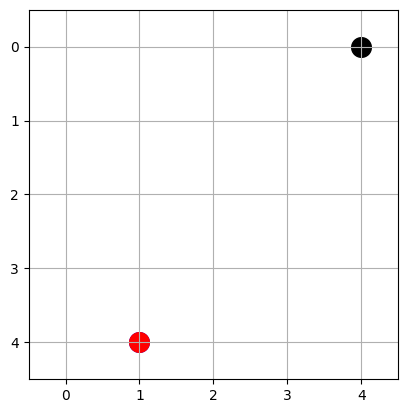

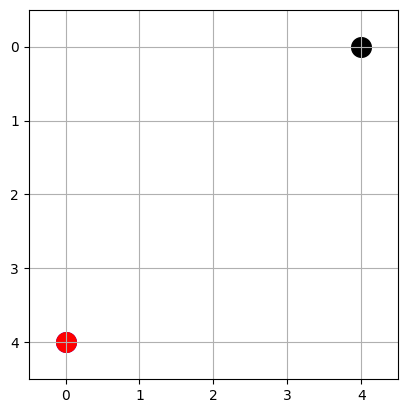

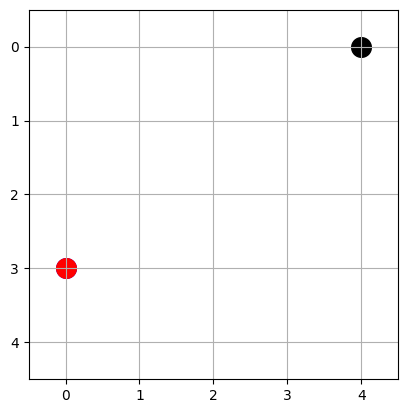

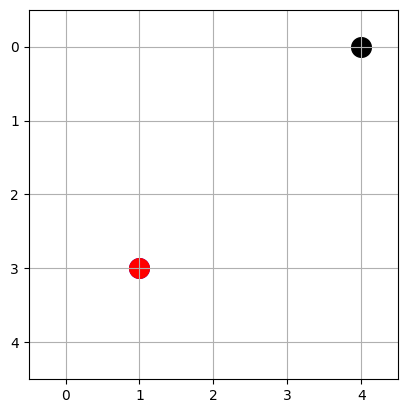

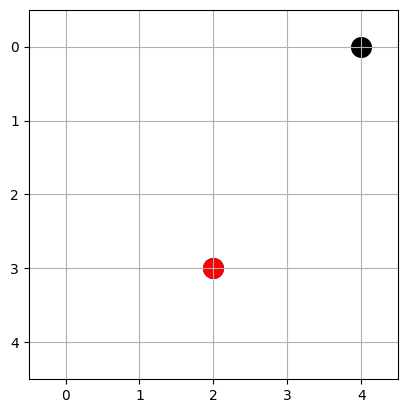

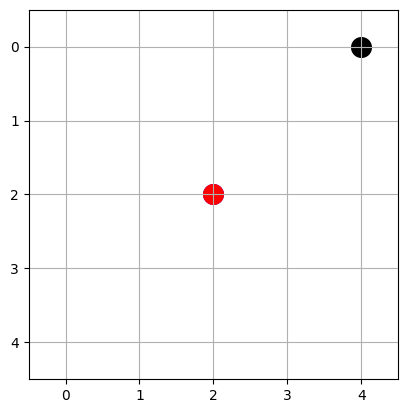

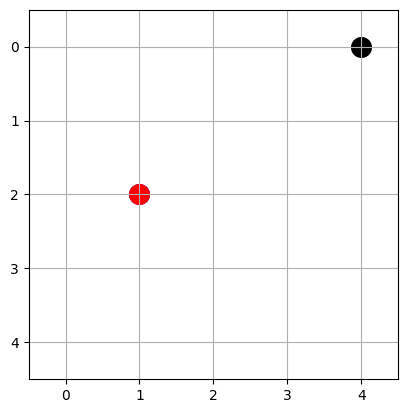

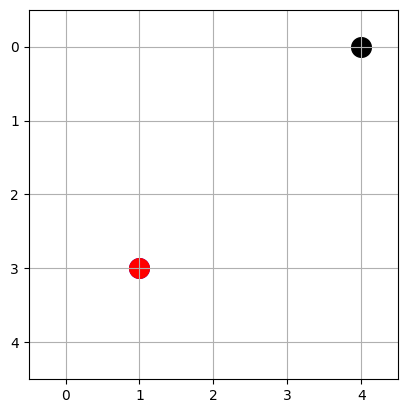

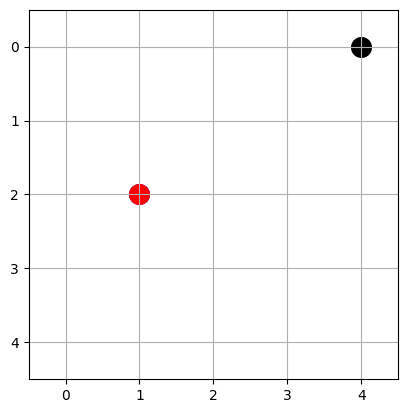

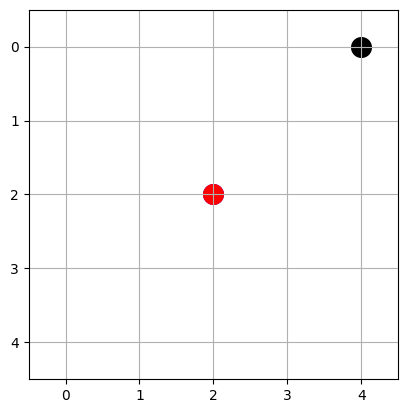

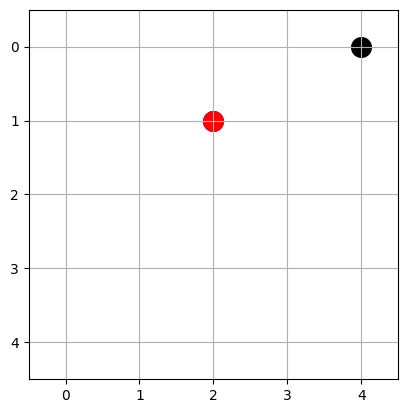

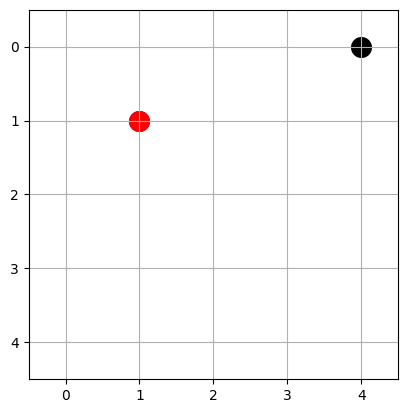

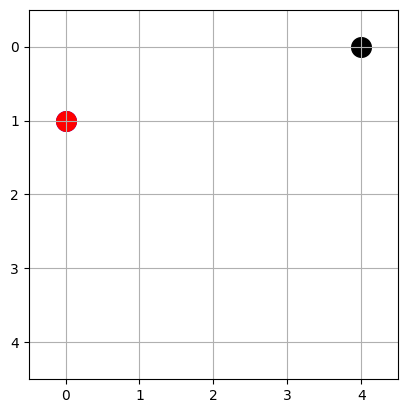

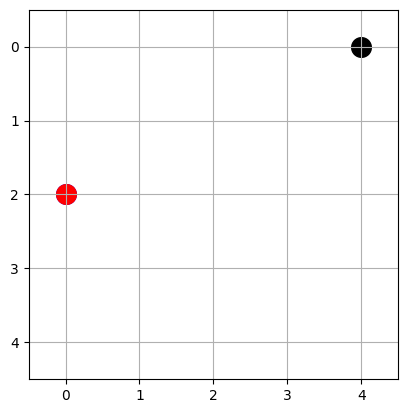

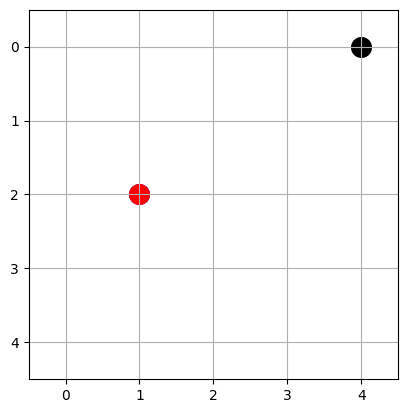

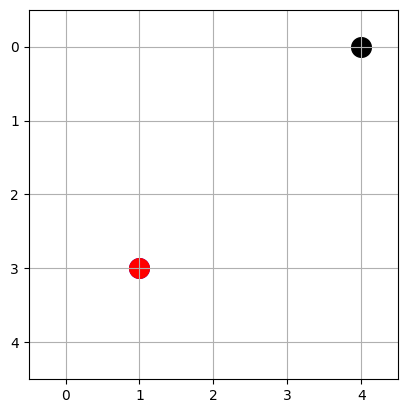

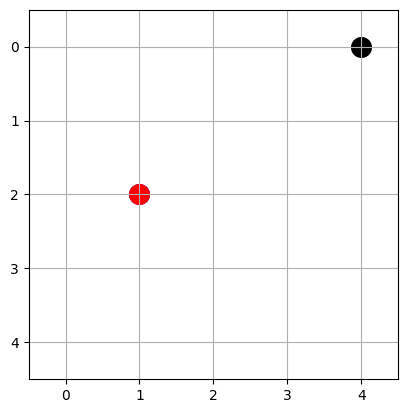

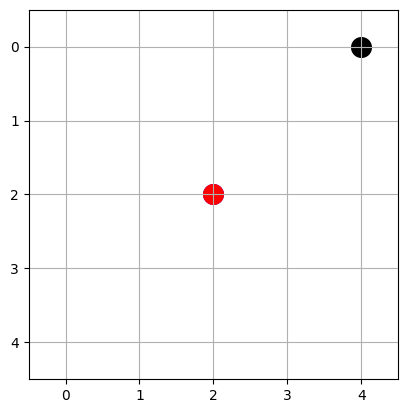

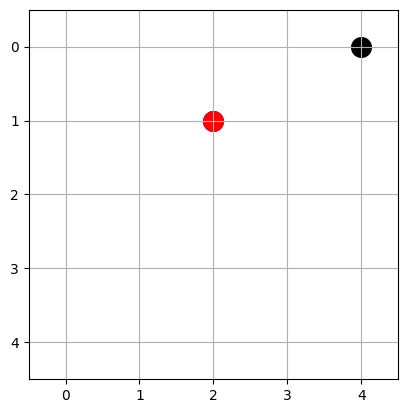

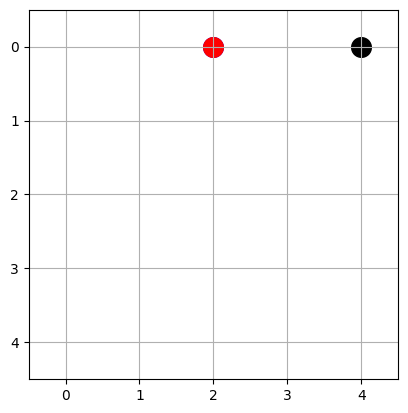

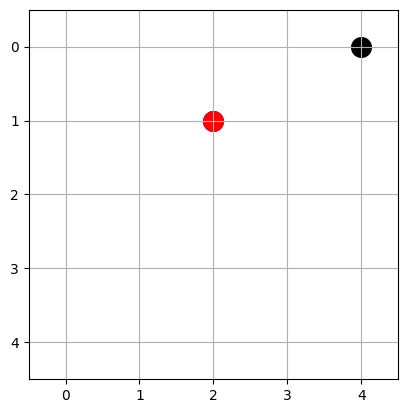

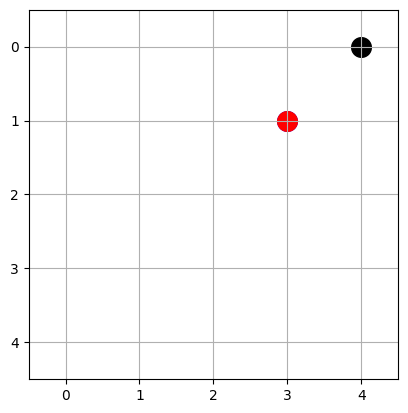

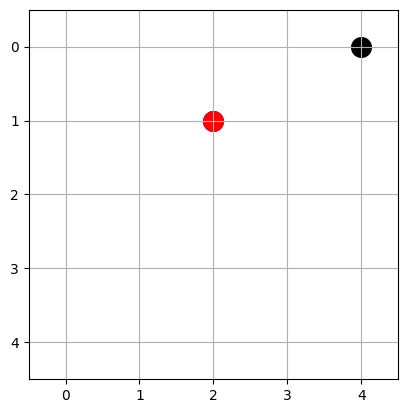

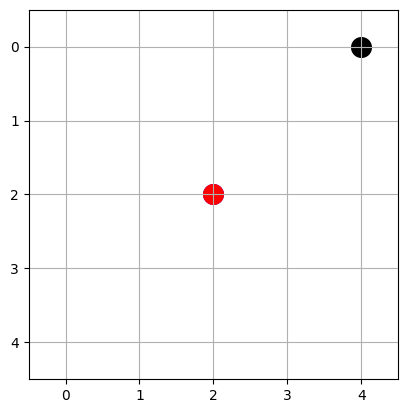

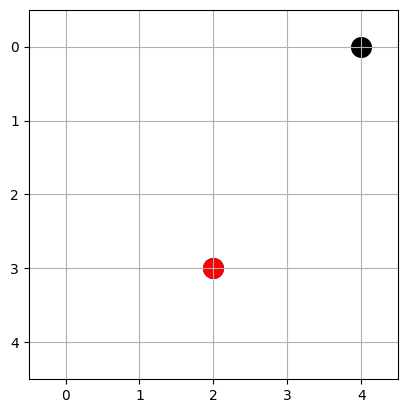

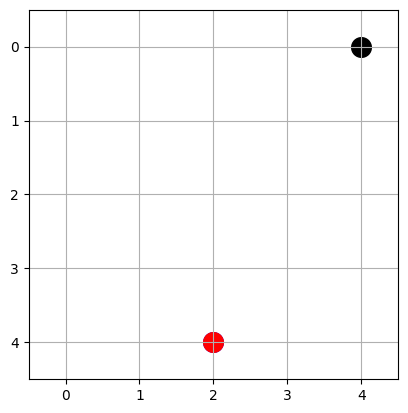

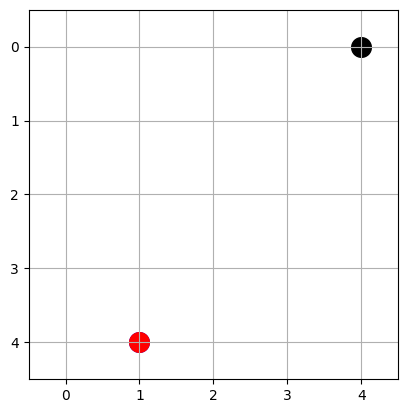

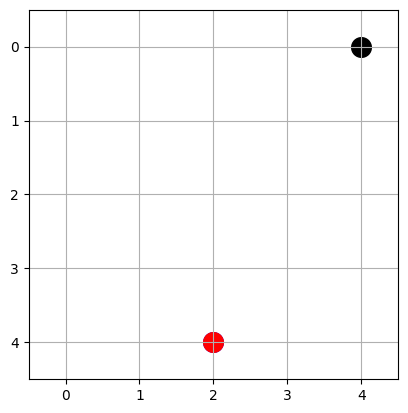

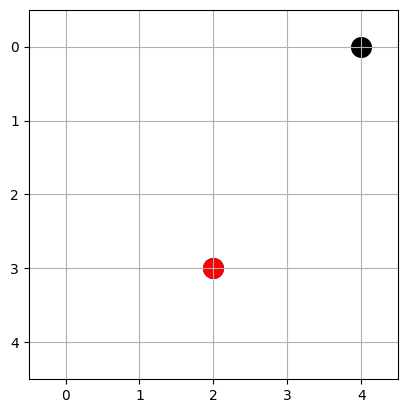

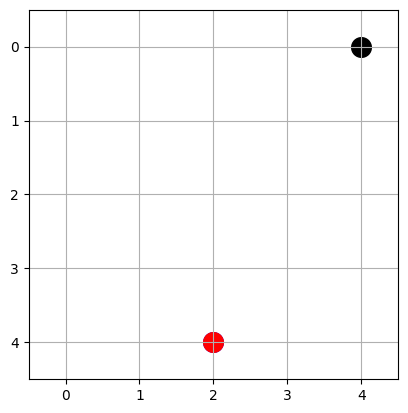

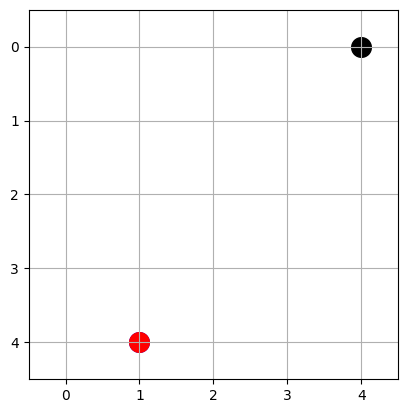

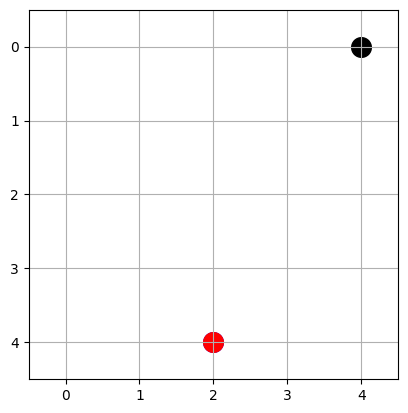

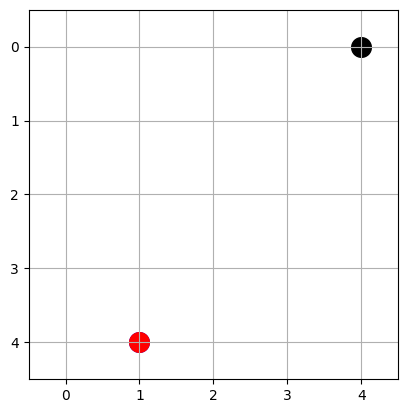

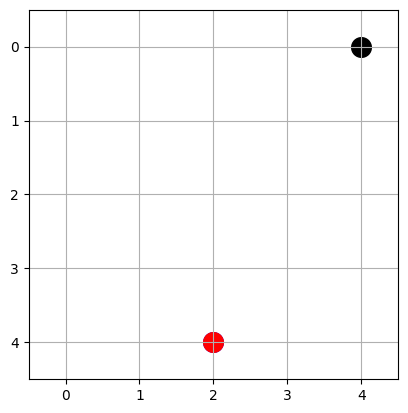

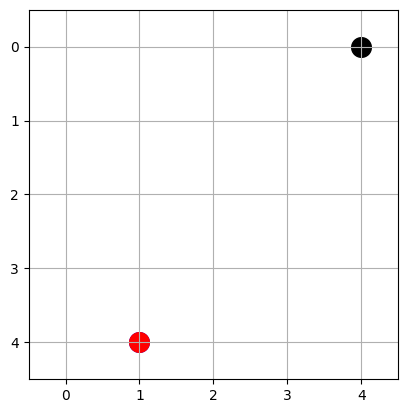

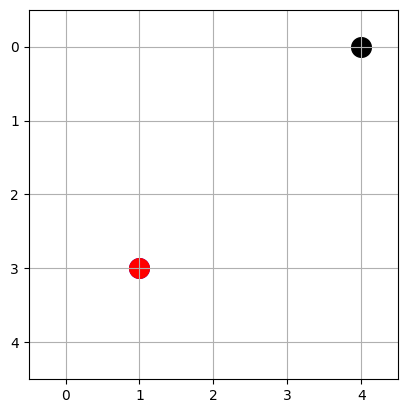

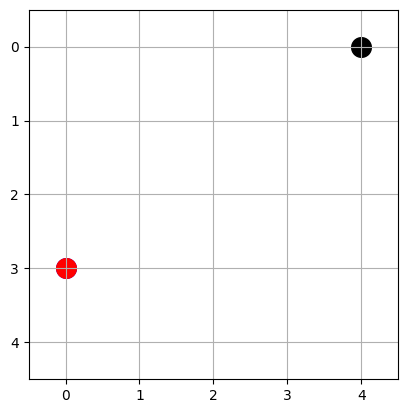

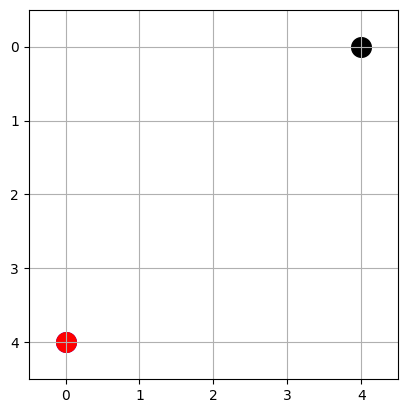

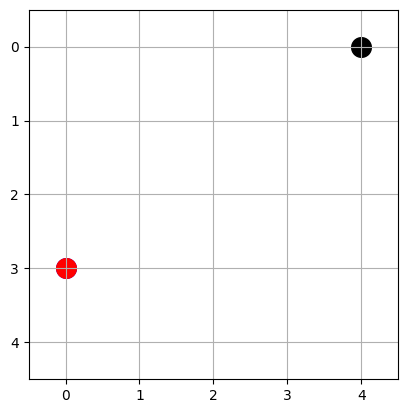

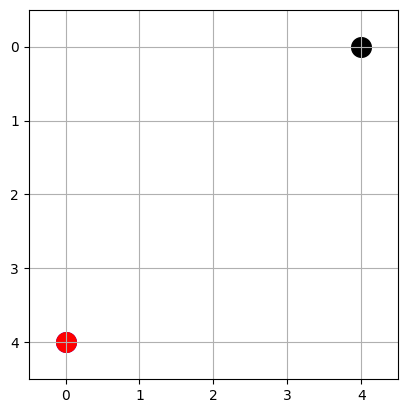

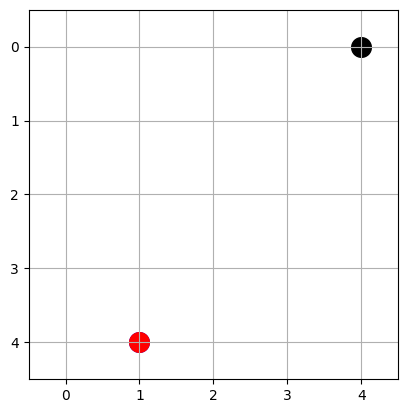

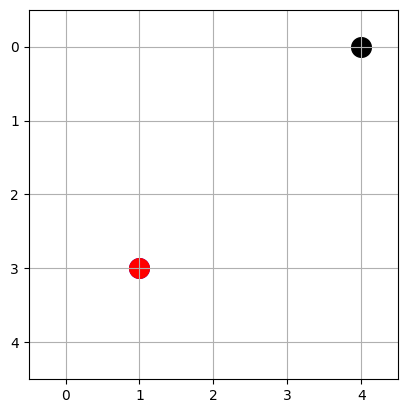

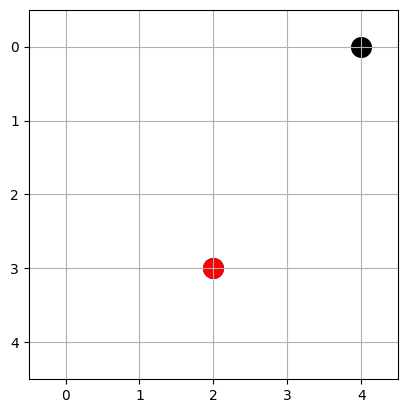

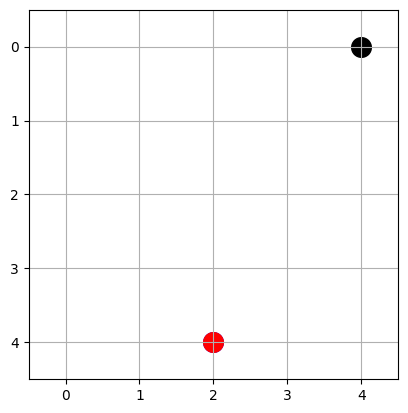

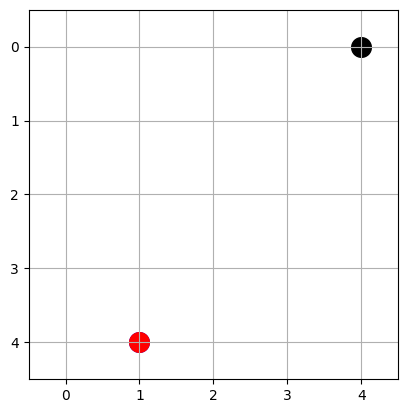

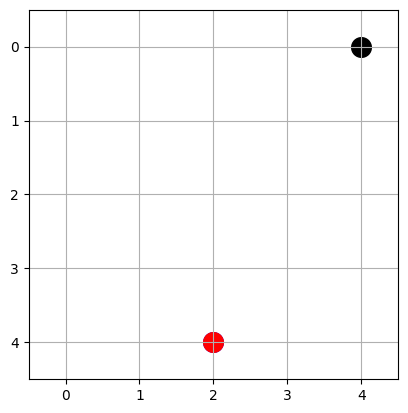

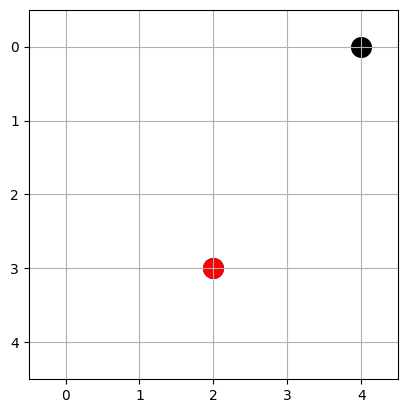

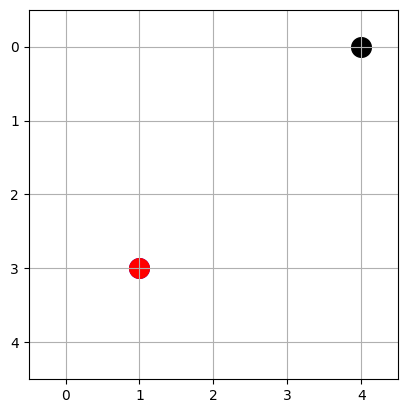

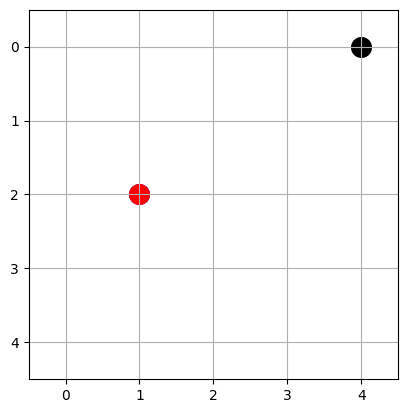

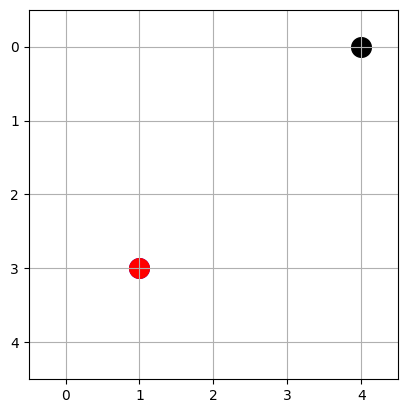

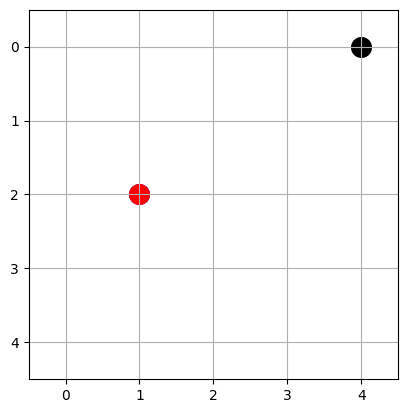

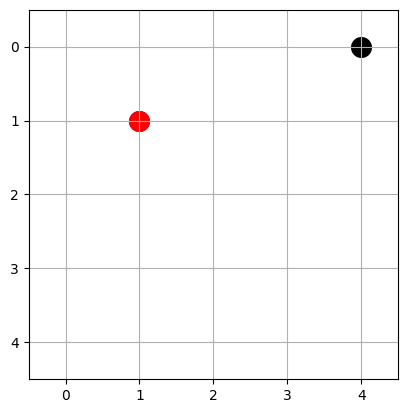

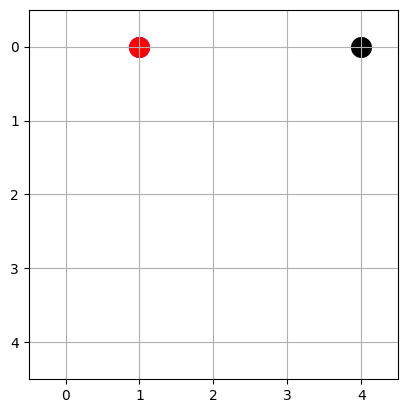

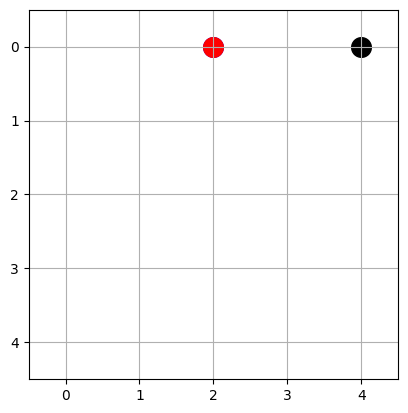

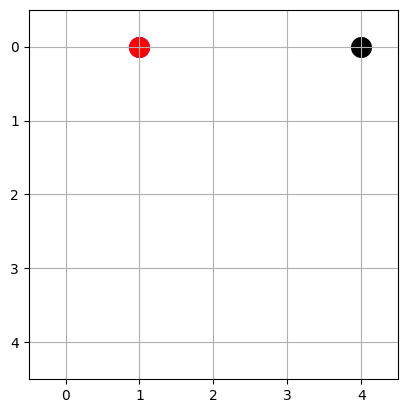

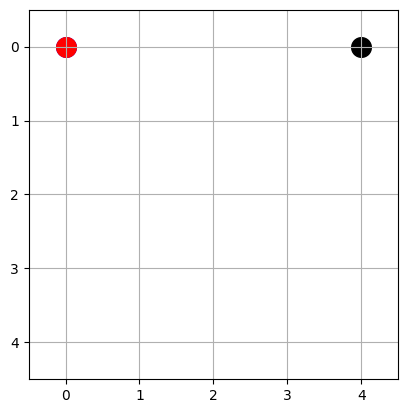

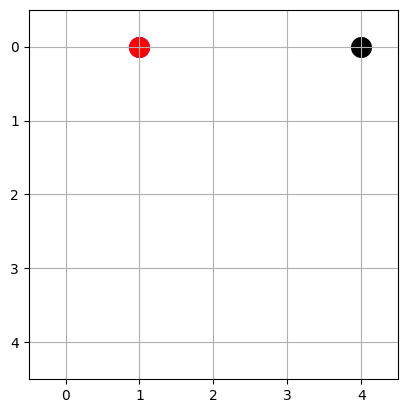

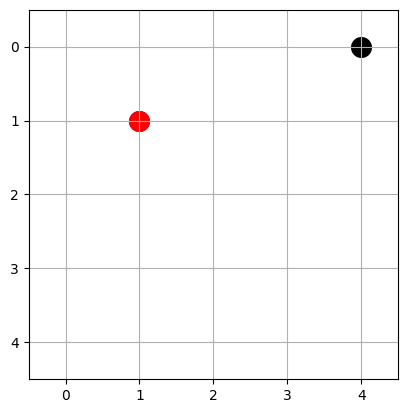

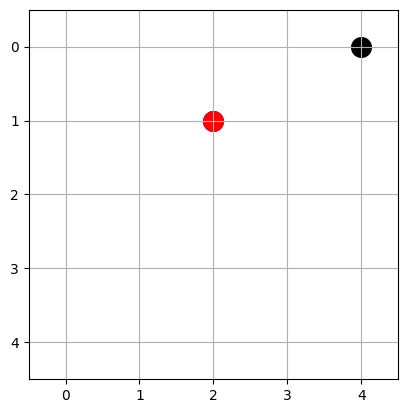

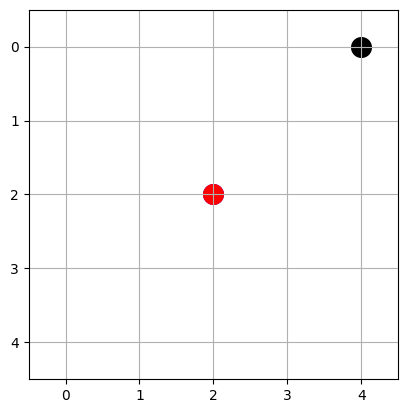

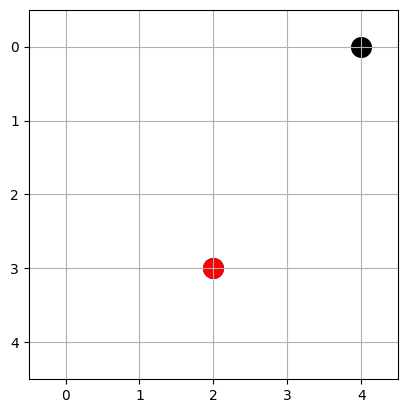

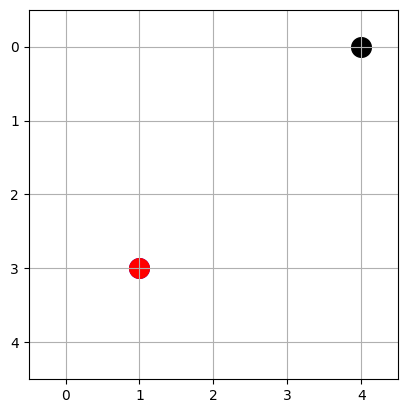

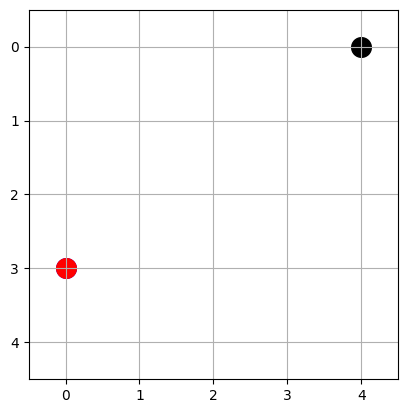

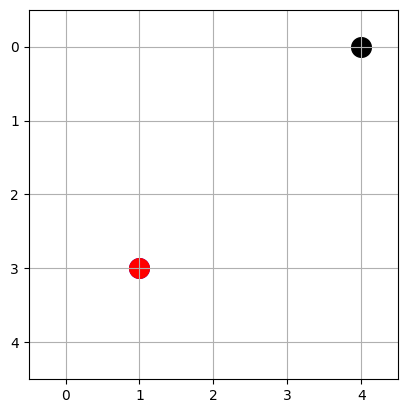

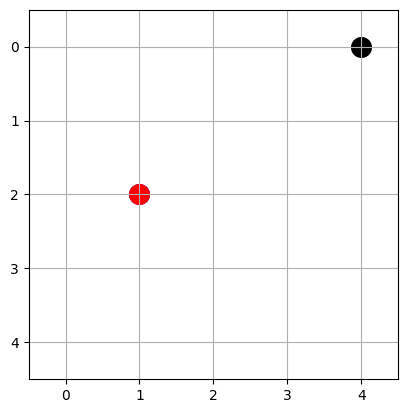

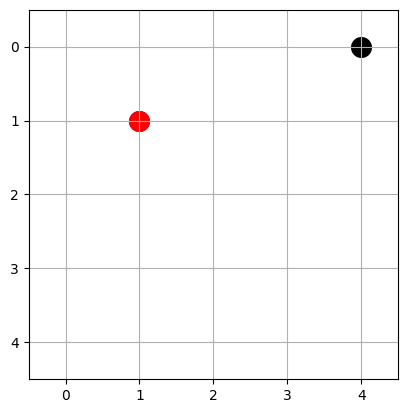

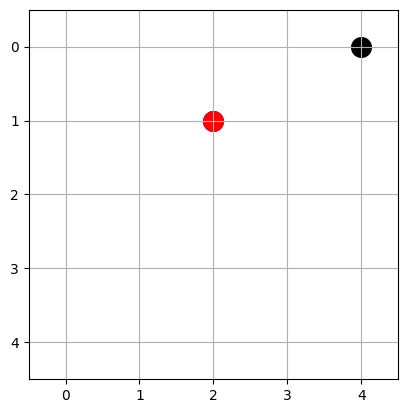

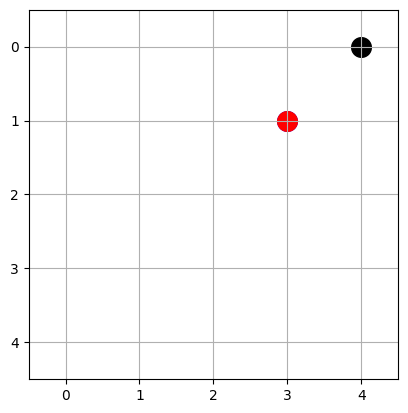

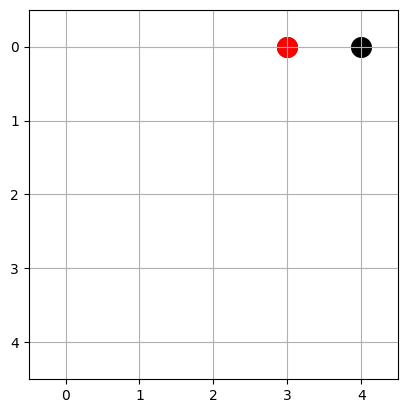

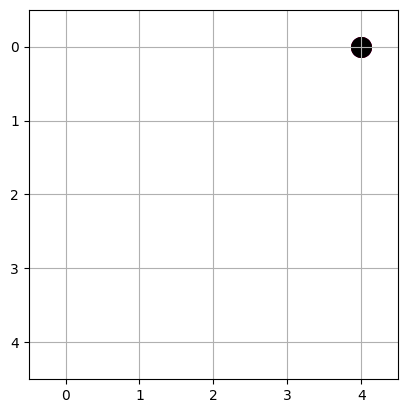

In [22]:
image_path = []
env.reset()
state = env.get_state()
total_reward = 0 
done = False
i = 0
image_path.append(draw_env(env, i))
while not done:
    i += 1
    a = np.random.choice(a=list(range(4)), p=policy[state])
    state, reward, done = env.step(a) 
    total_reward += reward
    image_path.append(draw_env(env, i))

In [23]:
total_reward

-135

In [24]:
from IPython.display import display, HTML
import imageio
import os

images = []
for img in image_path:
    images.append(imageio.imread(img))

# Сохраняем гифку
imageio.mimsave('policy.gif', images)

# Удаляем временные файлы
for img in image_path:
    os.remove(img)

/tmp/ipykernel_420564/1867955578.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img))
